# 3 - Neural Machine Translation by Jointly Learning to Align and Translate

In this third notebook on sequence-to-sequence models using PyTorch and TorchText, we'll be implementing the model from [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473). This model achives our best perplexity yet, ~27 compared to ~34 for the previous model.

## Introduction

As a reminder, here is the general encoder-decoder model:

![](assets/seq2seq1.png)

In the previous model, our architecture was set-up in a way to reduce "information compression" by explicitly passing the context vector, $z$, to the decoder at every time-step and by passing both the context vector and embedded input word, $d(y_t)$, along with the hidden state, $s_t$, to the linear layer, $f$, to make a prediction.

![](assets/seq2seq7.png)

Even though we have reduced some of this compression, our context vector still needs to contain all of the information about the source sentence. The model implemented in this notebook avoids this compression by allowing the decoder to look at the entire source sentence (via its hidden states) at each decoding step! How does it do this? It uses *attention*. 

Attention works by first, calculating an attention vector, $a$, that is the length of the source sentence. The attention vector has the property that each element is between 0 and 1, and the entire vector sums to 1. We then calculate a weighted sum of our source sentence hidden states, $H$, to get a weighted source vector, $w$. 

$$w = \sum_{i}a_ih_i$$

We calculate a new weighted source vector every time-step when decoding, using it as input to our decoder RNN as well as the linear layer to make a prediction. We'll explain how to do all of this during the tutorial.

## Preparing Data

Again, the preparation is similar to last time.

First we import all the required modules.

In [1]:
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import gridspec

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

import spacy
import numpy as np

import random
import math
import time

Set the random seeds for reproducability.

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Load the German and English spaCy models.

-> English To French MODEL

In [3]:
# spacy_de = spacy.load('de_core_news_sm')

spacy_en = spacy.load('en_core_web_sm')
spacy_fr = spacy.load('fr_core_news_sm')

We create the tokenizers.

In [4]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_fr(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

The fields remain the same as before.

In [5]:
TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

SRC = Field(tokenize = tokenize_fr, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

/home/jack/anaconda3/envs/cuda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Load the data.

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.en', '.fr'), root='/home/jack/torchstudy/03Mar/2_refactoring/.data',
                                                    fields = (SRC, TRG))

/home/jack/anaconda3/envs/cuda/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


Build the vocabulary.

In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Vocab Check

In [8]:
print(f"SRC Vocabs First : {list(SRC.vocab.freqs.keys())[0]}")
print(f"TRG Vocabs First : {list(TRG.vocab.freqs.keys())[0]}")

SRC Vocabs First : two
TRG Vocabs First : deux


Define the device.

In [9]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

Create the iterators.

In [10]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

/home/jack/anaconda3/envs/cuda/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Input size & made batch check

In [11]:
for example in train_iterator:
    print(f"SRC SIZE(Max length padded * batch_size) : {example.src.size()}")
    print(f"TRG SIZE(Max length padded * batch_size) : {example.trg.size()}")
    break

/home/jack/anaconda3/envs/cuda/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


SRC SIZE(Max length padded * batch_size) : torch.Size([21, 128])
TRG SIZE(Max length padded * batch_size) : torch.Size([25, 128])


# Layers input-output check

## 1. Encoder
-----
### 1.1 Embedding Layer

In [13]:
# input_dim = Total Vocab Size
# emb_dim = Embedding size which i want to embed
input_dim = len(SRC.vocab)
emb_dim = 620
embedding = nn.Embedding(input_dim, emb_dim).to(device)
embedded = embedding(example.src)
print(f"Embedding output : {embedded.size()}")
print("                             =>[padded_seq_len * batch_size * embedding_size]")

Embedding output : torch.Size([21, 128, 620])
                             =>[padded_seq_len * batch_size * embedding_size]


### 1.2 RNN Layer

In [13]:
padded_len, batch_size, emb_size = list(embedded.size())
rnn_hid_dim = 1000
batch_first = False # if True, input & output = [Batch_size, seq_len, emb_size]
rnn = nn.LSTM(emb_dim, rnn_hid_dim, num_layers = 1, batch_first=False, bidirectional = True).to(device)
outputs, (hidden, cell) = rnn(embedded)

In [14]:
emb_dim = 620
rnn_hid_dim = 1000
batch_first = False # if True, input & output = [Batch_size, seq_len, emb_size]
rnn = nn.GRU(emb_dim, rnn_hid_dim, num_layers = 6, batch_first=False, bidirectional = True).to(device)
outputs, hidden = rnn(embedded)

# outputs => all hidden state created by every time steps
# hidden => last hidden state
print("RNN output is all hidden state created by every time steps")
direction = 2
print( hidden[-1,:,:][0][0] == outputs.view(padded_len, batch_size, direction, rnn_hid_dim)[0,:,-1,:][0][0])
print("-"*100)


print("if you want to put hiddend state to rnn input, then size must be \n\
      **h_0** of shape (num_layers * num_directions, batch, hidden_size): tensor")
print("-"*100)

print(f"output size : {outputs.size()}")
print("               => [padded_len, batch_size, num_direction * hidden_size(direction outs are Concatnated) ]")

# seq_len, batch, num_direction, hidden_size
print("-"*100)
print(f"output split         : {outputs.view(padded_len, batch_size, direction, rnn_hid_dim)[0,0,1,:3]}")
print(f"output without split : {outputs[0,0,1000:1003]}")

print("-"*100)
print(f"hidden size : {hidden.size()}")
print("               => [num_direction * num_layers , batch_size, hidden_size ]")

RNN output is all hidden state created by every time steps
tensor(True, device='cuda:1')
----------------------------------------------------------------------------------------------------
if you want to put hiddend state to rnn input, then size must be 
      **h_0** of shape (num_layers * num_directions, batch, hidden_size): tensor
----------------------------------------------------------------------------------------------------
output size : torch.Size([21, 128, 2000])
               => [padded_len, batch_size, num_direction * hidden_size(direction outs are Concatnated) ]
----------------------------------------------------------------------------------------------------
output split         : tensor([-0.0528, -0.0197,  0.0152], device='cuda:1', grad_fn=<SliceBackward>)
output without split : tensor([-0.0528, -0.0197,  0.0152], device='cuda:1', grad_fn=<SliceBackward>)
----------------------------------------------------------------------------------------------------
hidden size

### 1.3 hidden state concat layer
-> This Layer is for uni-direction decoder hidden state

In [15]:
enc_hid_dim = 1000
dec_hid_dim = 1000
fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim).to(device)
# 제일 마지막 히든 레이어만 바라보기 때문에 -1, -2 처럼 사용함
changed_hidden = torch.tanh(fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))

In [16]:
print("-"*100)
print(f"hidden size : {changed_hidden.size()}")
print("               => [batch, hidden_size]")

----------------------------------------------------------------------------------------------------
hidden size : torch.Size([128, 1000])
               => [batch, hidden_size]


## 2. Attention

In [17]:
enc_hid_dim = 1000
dec_hid_dim = 1000
attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim).to(device)
v = nn.Linear(dec_hid_dim, 1, bias = False).to(device)

### 2.0 attention Initialize

In [18]:
attn = nn.Linear((1000 * 2) + 1000, 1000).to(device)

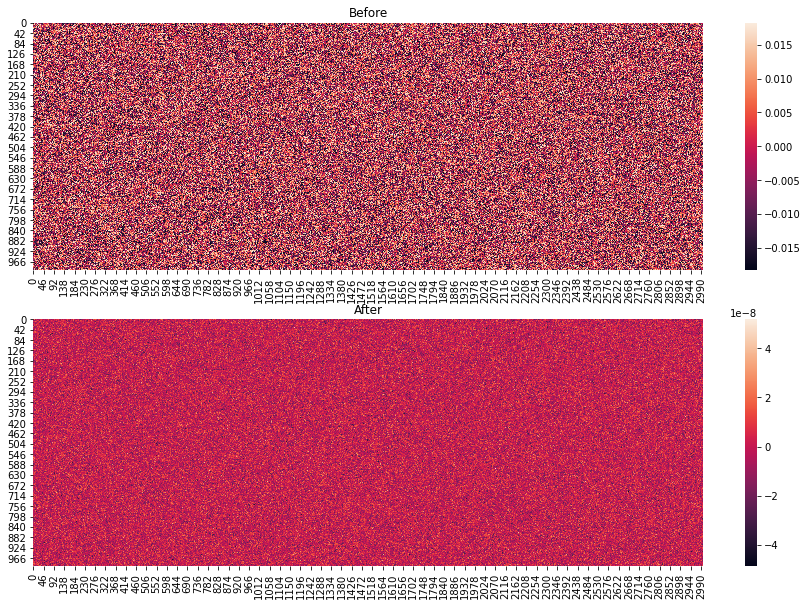

In [19]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10))

for name, parameters in attn.named_parameters():
    if name == 'weight':        
        sb.heatmap(parameters.data.cpu(), ax = ax[0]).set_title('Before')
        parameters.data = torch.Tensor(np.random.normal(0, 0.0001**2, list(parameters.data.size())))
        sb.heatmap(parameters.data.cpu(), ax = ax[1]).set_title('After')

In [20]:
encoder_outputs = outputs
batch_size = encoder_outputs.shape[1]
src_len = encoder_outputs.shape[0]
print(f"Batch size : {batch_size}, src_len :{src_len}")

Batch size : 128, src_len :21


### 2.1 디코더 스테이트를 인코더 스테이트 갯수 만큼 복사

In [21]:
print(changed_hidden.unsqueeze(1).repeat(1, src_len, 1).size())

torch.Size([128, 21, 1000])


### 2.2 인코더 히든스테이트 모음을 permutate 
-> 디코더 스테이트와 붙이기 위한 형태로 만드는 과정

In [22]:
print(encoder_outputs.permute(1, 0, 2).size())

torch.Size([128, 21, 2000])


### 2.3 복사된 디코더 스테이트와 인코더 스테이트를 concat 
-> 인코더 정방향 31 * 1000 , 인코더 역방향 31 * 1000, 현재 스텝의 디코더 스테이트 31 * 1000 합친것

In [23]:
print(torch.cat(
    (
        changed_hidden.unsqueeze(1).repeat(1, src_len, 1), 
        encoder_outputs.permute(1, 0, 2)
    )
    , dim = 2
).size())

torch.Size([128, 21, 3000])


### 2.4 concat한 스테이트에 FCN 연결

In [24]:
print(torch.tanh(
    attn(
        torch.cat(
            (
                changed_hidden.unsqueeze(1).repeat(1, src_len, 1), 
                encoder_outputs.permute(1, 0, 2)
            )
            ,dim = 2)
    )
).size())

RuntimeError: Tensor for argument #3 'mat2' is on CPU, but expected it to be on GPU (while checking arguments for addmm)

### 2.5 energy 및 $a_{ij}$ 생성

In [ ]:
print(
    F.softmax(
        v(
            torch.tanh(
                attn(
                    torch.cat(
                        (
                            changed_hidden.unsqueeze(1).repeat(1, src_len, 1), 
                            encoder_outputs.permute(1, 0, 2)
                        )
                        ,dim = 2
                    )
                )
            )
        ).squeeze(2), 
        dim=1
    ).size()
)

attention_value = F.softmax(
        v(
            torch.tanh(
                attn(
                    torch.cat(
                        (
                            changed_hidden.unsqueeze(1).repeat(1, src_len, 1), 
                            encoder_outputs.permute(1, 0, 2)
                        )
                        ,dim = 2
                    )
                )
            )
        ).squeeze(2), 
        dim=1
    )

## 3. decoder

### 3.1 decoder embedding
- 하나씩 뽑아서 사용하므로 임베딩 결과에 unsqueeze 필수적

In [ ]:
# input_dim = Total Vocab Size
# emb_dim = Embedding size which i want to embed
input_dim = len(TRG.vocab)
emb_dim = 620
dec_embedding = nn.Embedding(input_dim, emb_dim).to(device)
dec_embedded = dec_embedding(example.trg[0,:])
dec_embedded = dec_embedded.unsqueeze(0)
print(f"Embedding output : {dec_embedded.size()}")
print("                             =>[padded_seq_len * batch_size * embedding_size]")

### 3.2 attention 곱하기를 위해서 unsqueeze

In [ ]:
attention_value = attention_value.unsqueeze(1)
print(attention_value.size())

### 3.2 bmm을 위해 형변환

In [ ]:
# output -> encoder_outputs
print(outputs.permute(1, 0, 2).size())

### 3.3 배치 별로 내적, 내적된 히든스테이트(2000)가 나옴
- batch multiply
```
>>> input = torch.randn(10, 3, 4)
>>> mat2 = torch.randn(10, 4, 5)
>>> res = torch.bmm(input, mat2)
>>> res.size()
torch.Size([10, 3, 5])
```

In [ ]:
print(
    torch.bmm(
        attention_value, 
        outputs.permute(1, 0, 2)
    ).permute(1, 0, 2).size()
)

### 3.4 디코더의 입력 생성 완료, concat( attention, embedding)

In [25]:
weights = torch.bmm(attention_value, outputs.permute(1, 0, 2)).permute(1, 0, 2)
rnn_input = torch.cat(
    (
        dec_embedded, 
        weights
    ), dim = 2)
print(rnn_input.size())

NameError: name 'attention_value' is not defined

### 3.5 디코더 RNN 입력

In [26]:
# rnn_input : concat(어텐션, 임베딩)
# changed_hidden = 디코더 타임 스텝이 1일 때 사용하는 것이고, 여기서 출력되는 hidden을 다음 스텝에 그대로 사용
dec_rnn = nn.GRU((1000 * 2) + 620, 1000).to(device)
output, hidden = dec_rnn(rnn_input, changed_hidden.unsqueeze(0))
changed_hidden = hidden

NameError: name 'rnn_input' is not defined

In [27]:
(output == hidden).all()

NameError: name 'output' is not defined

### 3.6 타겟 단어 출력을 위한 FCN 연결

In [28]:
enc_hid_dim = 1000
dec_hid_dim = 1000
emb_dim = 620
output_dim = len(TRG.vocab)

dec_fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim).to(device)
dec_embedded = dec_embedded.squeeze(0)
output = output.squeeze(0)
weights = weights.squeeze(0)

prediction = dec_fc_out(torch.cat((output, weights, dec_embedded), dim = 1))

NameError: name 'dec_embedded' is not defined

In [268]:
print(f"Prediction : {prediction.size()}")
print("                        [Batch_size, Target Vocab_size]")

Prediction : torch.Size([128, 6660])
                        [Batch_size, Target Vocab_size]


## Building the Seq2Seq Model

### Encoder

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*. With a bidirectional RNN, we have two RNNs in each layer. A *forward RNN* going over the embedded sentence from left to right (shown below in green), and a *backward RNN* going over the embedded sentence from right to left (teal). All we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before. 

![](assets/seq2seq8.png)

We now have:

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

Where $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ and $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$.

As before, we only pass an input (`embedded`) to the RNN, which tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros. We'll also get two context vectors, one from the forward RNN after it has seen the final word in the sentence, $z^\rightarrow=h_T^\rightarrow$, and one from the backward RNN after it has seen the first word in the sentence, $z^\leftarrow=h_T^\leftarrow$.

The RNN returns `outputs` and `hidden`. 

`outputs` is of size **[src len, batch size, hid dim * num directions]** where the first `hid_dim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hid_dim` elements are hidden states from the top layer backward RNN. We can think of the third axis as being the forward and backward hidden states concatenated together other, i.e. $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

`hidden` is of size **[n layers * num directions, batch size, hid dim]**, where **[-2, :, :]** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence) and **[-1, :, :]** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).

As the decoder is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$, and we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function. 

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**Note**: this is actually a deviation from the paper. Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so we have changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.

In [12]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        # src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        # embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        # outputs = [src len, batch size, hid dim * num directions]
        # hidden = [n layers * num directions, batch size, hid dim]
        
        # hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        # outputs are always from the last layer
        
        # hidden [-2, :, : ] is the last of the forwards RNN 
        # hidden [-1, :, : ] is the last of the backwards RNN
        
        # initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        # outputs = [src len, batch size, enc hid dim * 2]
        # hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

Next up is the attention layer. This will take in the previous hidden state of the decoder, $s_{t-1}$, and all of the stacked forward and backward hidden states from the encoder, $H$. The layer will output an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1.

Intuitively, this layer takes what we have decoded so far, $s_{t-1}$, and all of what we have encoded, $H$, to produce a vector, $a_t$, that represents which words in the source sentence we should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

First, we calculate the *energy* between the previous decoder hidden state and the encoder hidden states. As our encoder hidden states are a sequence of $T$ tensors, and our previous decoder hidden state is a single tensor, the first thing we do is `repeat` the previous decoder hidden state $T$ times. We then calculate the energy, $E_t$, between them by concatenating them together and passing them through a linear layer (`attn`) and a $\tanh$ activation function. 

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$ 

This can be thought of as calculating how well each encoder hidden state "matches" the previous decoder hidden state.

We currently have a **[dec hid dim, src len]** tensor for each example in the batch. We want this to be **[src len]** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **[1, dec hid dim]** tensor, $v$.

$$\hat{a}_t = v E_t$$

We can think of $v$ as the weights for a weighted sum of the energy across all encoder hidden states. These weights tell us how much we should attend to each token in the source sequence. The parameters of $v$ are initialized randomly, but learned with the rest of the model via backpropagation. Note how $v$ is not dependent on time, and the same $v$ is used for each time-step of the decoding. We implement $v$ as a linear layer without a bias.

Finally, we ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1 by passing it through a $\text{softmax}$ layer.

$$a_t = \text{softmax}(\hat{a_t})$$

This gives us the attention over the source sentence!

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/teal blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

![](assets/seq2seq9.png)

In [13]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

### Maxout

In [14]:
class Maxout(nn.Module):
    def __init__(self, d_in, d_out, pool_size):
        super().__init__()
        self.d_in, self.d_out, self.pool_size = d_in, d_out, pool_size
        self.lin = nn.Linear(d_in, d_out * pool_size)

    def forward(self, inputs):
        shape = list(inputs.size())
        shape[-1] = self.d_out
        shape.append(self.pool_size)
        max_dim = len(shape) - 1
        out = self.lin(inputs)
        m, i = out.view(*shape).max(max_dim)
        return m

### Decoder

Next up is the decoder. 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$

The embedded input word, $d(y_t)$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $d(y_t)$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

We then pass $d(y_t)$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

The image below shows decoding the first word in an example translation.

![](assets/seq2seq10.png)

The green/teal blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [15]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, maxout_dim, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.max_out = Maxout((enc_hid_dim * 2) + dec_hid_dim + emb_dim, 500, maxout_dim)
        
        self.fc_out = nn.Linear(500, output_dim)
#         self.fc_out_orig = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
#         prediction = self.fc_out_orig(torch.cat((output, weighted, embedded), dim = 1))
        prediction = self.max_out(torch.cat((output, weighted, embedded), dim = 1))
        prediction = self.fc_out(prediction)
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0)

### Seq2Seq

This is the first model where we don't have to have the encoder RNN and decoder RNN have the same hidden dimensions, however the encoder has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if encoder_is_bidirectional else enc_dim`. 

This seq2seq encapsulator is similar to the last two. The only difference is that the `encoder` returns both the final hidden state (which is the final hidden state from both the forward and backward encoder RNNs passed through a linear layer) to be used as the initial hidden state for the decoder, as well as every hidden state (which are the forward and backward hidden states stacked on top of each other). We also need to ensure that `hidden` and `encoder_outputs` are passed to the decoder. 

Briefly going over all of the steps:
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, is fed into the encoder to receive $z$ and $H$
- the initial decoder hidden state is set to be the `context` vector, $s_0 = z = h_T$
- we use a batch of `<sos>` tokens as the first `input`, $y_1$
- we then decode within a loop:
  - inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all encoder outputs, $H$, into the decoder
  - receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
  - we then decide if we are going to teacher force or not, setting the next input as appropriate

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder,device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1

        return outputs

## Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one.

We initialise our parameters, encoder, decoder and seq2seq model (placing it on the GPU if we have one). 

In [17]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
MAX_OUT_DIM = 2
attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, MAX_OUT_DIM, attn)

model = Seq2Seq(enc, dec, device).to(device)

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

## initialize Parameters

In [18]:
# Just logic. not use
initializer = lambda name, param : {
                                    "attention.attn.weight" : nn.init.normal_(param.data, mean=0, std=0.001 ** 2),
                                    "bias" : nn.init.constant_(param.data, 0),
                                    "v": nn.init.constant_(param.data, 0),
                                    "other" : nn.init.normal_(param.data, mean=0, std=0.01 ** 2)
                                    }[name]

In [19]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'rnn.weight' in name:
            # recurrent weight matrix 
            # orthogonal should have dim 2 or more
            nn.init.orthogonal_(param.data)
        elif 'attention.v' in name:
            nn.init.zeros_(param.data)
        elif 'attention' in name:
            nn.init.normal_(param.data, 0, 0.001 ** 2)
        elif 'weight' in name:
            nn.init.normal_(param.data, 0, 0.01 ** 2)
        else:
            nn.init.constant_(param.data, 0)
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5943, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(6660, 256)
    (rnn): GRU(1280, 512)
    (max_out): Maxout(
      (lin): Linear(in_features=1792, out_features=1000, bias=True)
    )
    (fc_out): Linear(in_features=500, out_features=6660, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

Calculate the number of parameters. We get an increase of almost 50% in the amount of parameters from the last model. 

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,789,308 trainable parameters


We create an optimizer.

In [21]:
optimizer = optim.Adam(model.parameters())

We initialize the loss function.

In [22]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

We then create the training loop...

In [28]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
TRG_UNK_IDX = TRG.vocab.stoi[TRG.unk_token]
TRG_EOS_IDX = TRG.vocab.stoi[TRG.eos_token]
TRG_special_tokens = [TRG_EOS_IDX, TRG_PAD_IDX, TRG_UNK_IDX]

from sacrebleu import corpus_bleu

def get_speical_token(field):
    def get_stoi(idx):
        return field.vocab.stoi[idx]
    return [get_stoi(field.pad_token), get_stoi(field.unk_token), 
            get_stoi(field.eos_token)]

def get_itos_str(tokens, field):
    ignore_idx = get_speical_token(field)
    return ' '.join([field.vocab.itos[token] for token in tokens
                    if token not in ignore_idx])

def get_itos_batch(tokens_batch, field):
    return [get_itos_str(batch, field) for batch in tokens_batch]

def get_bleu_score(output, trg, trg_field):
    with torch.no_grad():
        output_token = output.argmax(-1)

    # 문장 별로 해야돼서 permute 해야 함
    output_token = output_token.permute(1, 0)
    trg = trg.permute(1, 0)
    system = get_itos_batch(output_token, trg_field)
    refs = get_itos_batch(trg, trg_field)
#     print(system, refs)
    bleu = corpus_bleu(system, [refs], force=True).score

    return bleu

In [29]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    t_bleu = 0
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        t_bleu += get_bleu_score(output, trg, TRG)
        output_dim = output.shape[-1]
        batch_size = output.shape[1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
            
#         #trg = [(trg len - 1) * batch size]
#         #output = [(trg len - 1) * batch size, output dim]
#         output_tokens = torch.argmax(output, dim=1).view(batch_size, -1).tolist()
#         for j, item in enumerate(output_tokens):
#             output_tokens[j] = [str(k) for k in item]

#         trg_tokens = trg.view(batch_size, -1).tolist()
#         for j, item in enumerate(trg_tokens):
#             trg_tokens[j] = [[str(k) for k in item]]
            
# #         print("output :", output_tokens[0])
# #         print("target :", trg_tokens[0][0])
#         t_bleu += bleu_score(output_tokens, trg_tokens)
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator), t_bleu / len(iterator)

...and the evaluation loop, remembering to set the model to `eval` mode and turn off teaching forcing.

In [30]:
epoch = 0
def evaluate(model, iterator, criterion):
    val_file = open(f"./valdata/val.text.{epoch}", "w")
    model.eval()
    
    epoch_loss = 0
    
    t_bleu = 0
    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]
            t_bleu += get_bleu_score(output, trg, TRG)
            output_dim = output.shape[-1]
            batch_size = output.shape[1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            
#             output_tokens = torch.argmax(output, dim=1).view(batch_size, -1).tolist()
#             for j, item in enumerate(output_tokens):
#                 output_tokens[j] = [str(k) for k in item]

#             trg_tokens = trg.view(batch_size, -1).tolist()
#             for j, item in enumerate(trg_tokens):
#                 val_file.write(" ".join([TRG.vocab.itos[k] for k in item]) + "\n")
#                 trg_tokens[j] = [[str(k) for k in item]]
            
#             t_bleu += bleu_score(output_tokens, trg_tokens)
            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator), t_bleu / len(iterator)

Finally, define a timing function.

In [31]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Then, we train our model, saving the parameters that give us the best validation loss.

In [32]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_bleu = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss, valid_bleu = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Train BLEU: {train_bleu:7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f} | Val. BLEU: {valid_bleu:7.3f}')

/home/jack/anaconda3/envs/cuda/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 01 | Time: 2m 57s
	Train Loss: 5.271 | Train PPL: 194.574 | Train BLEU:   0.437
	 Val. Loss: 5.187 |  Val. PPL: 178.880 | Val. BLEU:   0.942
Epoch: 02 | Time: 3m 1s
	Train Loss: 4.365 | Train PPL:  78.662 | Train BLEU:   1.687
	 Val. Loss: 4.539 |  Val. PPL:  93.602 | Val. BLEU:   4.579
Epoch: 03 | Time: 3m 2s
	Train Loss: 3.685 | Train PPL:  39.857 | Train BLEU:   5.952
	 Val. Loss: 4.072 |  Val. PPL:  58.689 | Val. BLEU:  10.801
Epoch: 04 | Time: 3m 0s
	Train Loss: 3.114 | Train PPL:  22.503 | Train BLEU:  12.466
	 Val. Loss: 3.918 |  Val. PPL:  50.315 | Val. BLEU:  18.958
Epoch: 05 | Time: 2m 59s
	Train Loss: 2.703 | Train PPL:  14.922 | Train BLEU:  18.210
	 Val. Loss: 3.305 |  Val. PPL:  27.250 | Val. BLEU:  26.523
Epoch: 06 | Time: 2m 58s
	Train Loss: 2.365 | Train PPL:  10.649 | Train BLEU:  23.062
	 Val. Loss: 3.073 |  Val. PPL:  21.615 | Val. BLEU:  31.023
Epoch: 07 | Time: 3m 0s
	Train Loss: 2.110 | Train PPL:   8.249 | Train BLEU:  27.102
	 Val. Loss: 3.124 |  Val. PP

Finally, we test the model on the test set using these "best" parameters.

In [39]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss, test_bleu = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} | Test Bleu : {test_bleu:.3f}')

| Test Loss: 2.481 | Test PPL:  11.950 | Test Bleu : 42.259


We've improved on the previous model, but this came at the cost of doubling the training time.

In the next notebook, we'll be using the same architecture but using a few tricks that are applicable to all RNN architectures - packed padded sequences and masking. We'll also implement code which will allow us to look at what words in the input the RNN is paying attention to when decoding the output.

## Maxout

## Inference & BLEU

In [45]:
def translate_sentence(model, token, max_length=50):
    text_to_indices = token
    sentence_tensor = torch.LongTensor(text_to_indices).to(device)
    model.eval()
    # Build encoder hidden, cell state
    with torch.no_grad():
        embedded = model.encoder.dropout(model.encoder.embedding(sentence_tensor))
        encoder_outputs, hidden = model.encoder.rnn(embedded)
        hidden = torch.tanh(model.encoder.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        outputs = [2] #pad_idx
        m_decoder = model.decoder
        for _ in range(max_length):
            previous_word = torch.LongTensor([outputs[-1]]).to(device)

            with torch.no_grad():
                
                embedded = m_decoder.dropout(m_decoder.embedding(previous_word))
                
                a = m_decoder.attention(hidden.view(-1,512), encoder_outputs)
                a = a.unsqueeze(1)
                
                weighted = torch.bmm(a, encoder_outputs.permute(1,0,2))
                weighted = weighted.permute(1, 0, 2)
                
                if len(embedded.size()) == 2:
                    embedded = embedded.unsqueeze(1)

                rnn_input = torch.cat((embedded, weighted), dim = 2)
                output, hidden = m_decoder.rnn(rnn_input, hidden.view(-1,1,512))

                embedded = embedded.squeeze(0)
                output = output.squeeze(0)
                weighted = weighted.squeeze(0)
                prediction = m_decoder.max_out(torch.cat((output, weighted, embedded), dim = 1))
                prediction = m_decoder.fc_out(prediction)
                best_guess = prediction.argmax(1).item()

            outputs.append(best_guess)

            # Model predicts it's the end of the sentence
            if best_guess == 3:
                break

    return outputs

In [46]:
model.load_state_dict(torch.load('tut3-model.pt'))

<All keys matched successfully>

In [47]:
def sentence_to_tokens(sentence):
    indeces = [SRC.vocab[i] for i in SRC.tokenize(sentence.lower())][::-1]
    test_sample = torch.Tensor(indeces).long().view(-1,1)
    return test_sample

In [52]:
sentence = "A group of men are loading cotton onto a truck"
test_sample = sentence_to_tokens(sentence)

In [53]:
" ".join([TRG.vocab.itos[i] for i in translate_sentence(model, test_sample)])

"<sos> en tenue de rodéo , des hommes d'un groupe d'un groupe de groupe de personnes . <eos>"